In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hbo-and-hbo-max-content-dataset/HBO_Content.csv
/kaggle/input/hbo-and-hbo-max-content-dataset/HBO_MAX_Content.csv


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler,OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from datetime import datetime
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

DEGREE = 4


def preprocess_dataset(input_csv, output_csv):
    df = pd.read_csv(input_csv)
    
    df = remove_columns(df)
    df = replace_null_type_values_pandas(df)
    df = df.dropna(subset=['imdb_score', 'rotten_score'], how='all')
    df = scale_rotten_to_imdb(df)
    df = transcode_genres(df)
    df = transcode_type(df)
    
    df.to_csv(output_csv, index=False)
    
def remove_columns(df):
    columns_to_remove = ['index', 'title', 'rating', 'platforms_acorntv', 'platforms_amazon_prime',
                         'platforms_cinemax', 'platforms_epix', 'platforms_fandor',
                         'platforms_free', 'platforms_fubo_tv', 'platforms_hbo',
                         'platforms_hbo_max', 'platforms_hoopla', 'platforms_hulu_plus',
                         'platforms_kanopy', 'platforms_netflix', 'platforms_shoutfactorytv',
                         'platforms_sundancenow', 'platforms_syfy_tveverywhere', 'platforms_tlc_go',
                         'platforms_viceland_tve']
    
    df = df.drop(columns=columns_to_remove)
    return df

def replace_null_type_values_pandas(df):
    df['type'].fillna('Movie', inplace=True)
    return df

def scale_rotten_to_imdb(df):
    df['rotten_score'] = df['rotten_score'] / 10
    df['rotten_score'].fillna(df['imdb_score'], inplace=True)
    return df

def transcode_genres(df):
    df['genres_transcoded_bin'] = pd.Series(dtype=str)  # Adding a new column with NaN values
    df['genres_transcoded'] = pd.Series(dtype=int)  # Adding a new column with NaN values
    cols = ['genres_Action_Adventure',
            'genres_Animation',
            'genres_Biography',
            'genres_Children',
            'genres_Comedy',
            'genres_Crime',
            'genres_Cult',
            'genres_Documentary',
            'genres_Drama',
            'genres_Family',
            'genres_Fantasy',
            'genres_Food',
            'genres_Game Show',
            'genres_History',
            'genres_Horror',
            'genres_Independent',
            'genres_LGBTQ',
            'genres_Musical',
            'genres_Mystery',
            'genres_Reality',
            'genres_Romance',
            'genres_Science_Fiction',
            'genres_Sport',
            'genres_Stand_up_Talk',
            'genres_Thriller',
            'genres_Travel']
    df['genres_transcoded_bin'] = df[cols].apply(lambda row: ''.join(row.values.astype(str)), axis=1)  # combine the genres into a binary number
    df['genres_transcoded'] = df['genres_transcoded_bin'].apply(lambda row: int(row, 2))  # binary to int
    return df

def transcode_type(df):
    df['type_transcoded'] = pd.Series(dtype=int) 
    df['type_transcoded'] = df['type'].apply(lambda row: 1 if row == "Movie" else 0)
    return df

def ordinary_least_squares (features, X_train, y_train, X_test, y_test):
    numeric_features = ['year'] 
    categorical_features = ['genres_transcoded']

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    print('The r2 is: ', r2)
    print('The rmse is: ', rmse)
    r_sq = model.score(X_test, y_test)
    print(f"coefficient of determination: {r_sq}")
    
def bayesian_regression(features, X_train, y_train, X_test, y_test):
    numeric_features = features.columns
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ])

    # Combine preprocessing with the Bayesian Ridge Regression model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', BayesianRidge())
    ])
    
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    print('The r2 is: ', r2)
    print('The rmse is: ', rmse)
    r_sq = model.score(X_test, y_test)
    print(f"Coefficient of determination: {r_sq}")
    
def knn_regression(X_train, y_train, X_test, y_test):
    knn = KNeighborsRegressor(n_neighbors=5, n_jobs=-1, weights="distance")
    print('KNN regression training started...')
    knn.fit(X_train, y_train)
    print('Training completed!')
    predictions = knn.predict(X_test)
    r2 = r2_score(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    print('The r2 is: ', r2)
    print('The rmse is: ', rmse)
    r_sq = knn.score(X_test, y_test)
    print(f"coefficient of determination: {r_sq}")
    results = {
            "expected_output": y_test,
            "predicted_output": predictions
            }
    results_df = pd.DataFrame(results)
    print(results_df)
    
def sgd_regression(features, X_train, y_train, X_test, y_test):
    numeric_features = features.columns
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ])

    # Preprocessing with the SGD Regressor model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', SGDRegressor(max_iter=1000, tol=1e-3))  
    ])

    num_epochs = 5
    for epoch in range(num_epochs):
        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        # Calculate and print mean squared error for each epoch
        mse = mean_squared_error(y_test, predictions)
        print(f"Epoch {epoch + 1}, Mean Squared Error: {mse}")
        r2 = r2_score(y_test, predictions)
        print('The r2 is: ', r2)
        r_sq = model.score(X_test, y_test)
        print(f"coefficient of determination: {r_sq}")
        
    results = {
            "expected_output": y_test,
            "predicted_output": predictions
            }
    results_df = pd.DataFrame(results)
    sns.lmplot(x="expected_output", y="predicted_output", data=results_df, order=2)

def linear_hyperparamets_tuning(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    print(f"Mean Squared Error: {mse}")

    # Hyperparameter Tuning with Grid Search
    param_grid = {'fit_intercept': [True, False], "copy_X":[True, False], "positive": [True, False]}
    for i in range(10):
        grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5)
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        print(f"Best Hyperparameters: {best_params}")

        # train the final model with best hyperparameters
        final_model = grid_search.best_estimator_
        final_model.fit(X_train, y_train)

        final_predictions = final_model.predict(X_test)

    # Evaluatation
    final_mse = mean_squared_error(y_test, final_predictions)
    print(f"Mean Squared Error (Final Model): {final_mse}")
    r2 = r2_score(y_test, predictions)
    print('The r2 is: ', r2)
    r_sq = model.score(X_test, y_test)
    print(f"coefficient of determination: {r_sq}")
        
    results = {
            "expected_output": y_test,
            "predicted_output": predictions
            }
    results_df = pd.DataFrame(results)
    sns.lmplot(x="expected_output", y="predicted_output", data=results_df, order=2)
    
def random_forest_regression(X_train, y_train, X_test, y_test):
    # Create and train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    r2 = r2_score(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    print('Random Forest Regression Results:')
    print('The r2 is:', r2)
    print('The rmse is:', rmse)

    return model

def polynomial_regression():
    print('Polynomial regression data transformation started...')
    X_train_ = PolynomialFeatures(degree=DEGREE, interaction_only=True, include_bias=True).fit_transform(X_train)
    print('Data transformation completed!')
    print(f"Transformed data: \n{X_train_}")
    model = LinearRegression()
    print('Polynomial regression training started...')
    model.fit(X_train_, y_train)
    print('Training completed!')
    X_test_ = PolynomialFeatures(degree=DEGREE, interaction_only=True, include_bias=True).fit_transform(X_test)
    predictions = model.predict(X_test_)
    r2 = r2_score(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    print('The r2 is: ', r2)
    print('The rmse is: ', rmse)
    r_sq = model.score(X_test_, y_test)
    print(f"coefficient of determination: {r_sq}")
    print(f"intercept: {model.intercept_}")
    # print(f"coefficients: {model.coef_}")
    results = {
            "expected_output": y_test,
            "predicted_output": predictions
            }
    results_df = pd.DataFrame(results)
    print(results_df)
    timestamp = f"{datetime.now().date()}_{datetime.now().time().isoformat()}" 
    results_path = os.path.join(os.getcwd(), f"results_pr_{timestamp}.csv") #TODO CHANGE PATH
    results_df.to_csv(results_path)
    print(f"Polynomial regression results written to {results_path}")
    print(f"Creating plot of the results...")
    # sns.regplot(x="expected_output", y="predicted_output", data=results_df, x_estimator=np.mean)
    sns.lmplot(x="expected_output", y="predicted_output", data=results_df, order=2)
    results_regfig_path = os.path.join(os.getcwd(), f"results_pr_{timestamp}_regplot.png") #TODO CHANGE PATH
    plt.savefig(results_regfig_path)
    # sns.pairplot(results_df)
    # plt.savefig(results_fig_path)
    print(f"Plots of the results successfully created!")
    print(f"Plots of the results successfully saved at {results_regfig_path}!")
    
def linear_regression():
    model = LinearRegression()
    print('Linear regression training started...')
    model.fit(X_train, y_train)
    print('Training completed!')
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    print('The r2 is: ', r2)
    print('The rmse is: ', rmse)
    r_sq = model.score(X_test, y_test)
    print(f"coefficient of determination: {r_sq}")
    results = {
            "expected_output": y_test,
            "predicted_output": predictions
            }
    results_df = pd.DataFrame(results)
    print(results_df)
    timestamp = f"{datetime.now().date()}_{datetime.now().time().isoformat()}"
    results_path = os.path.join(os.getcwd(), f"results_lr_{timestamp}.csv") #TODO CHANGE PATH
    results_df.to_csv(results_path)
    print(f"Linear regression results written to {results_path}")
    print(f"Creating plot of the results...")
    sns.regplot(x="expected_output", y="predicted_output", data=results_df)
    results_regfig_path = os.path.join(os.getcwd(), f"results_lr_{timestamp}_regplot.png") #TODO CHANGE PATH
    plt.savefig(results_regfig_path)
    print(f"Plots of the results successfully created!")
    print(f"Plots of the results successfully saved at {results_regfig_path}!")
    
def polynomial_regression_testy():
    print('Polynomial regression data transformation started...')
    
    # Instantiate PolynomialFeatures and fit_transform on training data
    poly = PolynomialFeatures(degree=DEGREE, interaction_only=True, include_bias=True)
    X_train_poly = poly.fit_transform(X_train)
    
    # Regularization (Ridge regression)
    alpha = 10.0  # Adjust the regularization strength
    model = Ridge(alpha=alpha)

    print('Polynomial regression training started...')
    model.fit(X_train_poly, y_train)
    print('Training completed!')

    X_test_poly = poly.transform(X_test)
    
    predictions = model.predict(X_test_poly)
    
    r2 = r2_score(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    print('The r2 is: ', r2)
    print('The rmse is: ', rmse)
    r_sq = model.score(X_test_poly, y_test)
    print(f"coefficient of determination: {r_sq}")
    print(f"intercept: {model.intercept_}")
    
    
if __name__ == "__main__":
    # Load the preprocessed dataset
    dataset_result_path = os.path.join("/kaggle/working/", "HBO_Content_preprocessed.csv") #TODO CHANGE PATH
    dataset_path = os.path.join("/kaggle/input/hbo-and-hbo-max-content-dataset/", "HBO_Content.csv") #TODO CHANGE PATH
    if not os.path.isfile(dataset_result_path):
        preprocess_dataset(dataset_path, dataset_result_path)
    df = pd.read_csv(dataset_result_path)

    # Select features and target variable
    features = df[['year', 'genres_transcoded']]
    target = df['imdb_score']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)


In [16]:
print("bayesian")
bayesian_regression(features, X_train, y_train, X_test, y_test) 

bayesian
The r2 is:  0.08434013844829935
The rmse is:  1.1160838667734323
Coefficient of determination: 0.08434013844829935


sdg
Epoch 1, Mean Squared Error: 1.2436149557608718
The r2 is:  0.08583107880019969
coefficient of determination: 0.08583107880019969
Epoch 2, Mean Squared Error: 1.242657106453796
The r2 is:  0.08653518424993334
coefficient of determination: 0.08653518424993334
Epoch 3, Mean Squared Error: 1.2431398915022116
The r2 is:  0.08618029378738534
coefficient of determination: 0.08618029378738534
Epoch 4, Mean Squared Error: 1.2442104475157714
The r2 is:  0.08539333876447708
coefficient of determination: 0.08539333876447708
Epoch 5, Mean Squared Error: 1.2399551898736796
The r2 is:  0.08852133611613178
coefficient of determination: 0.08852133611613178


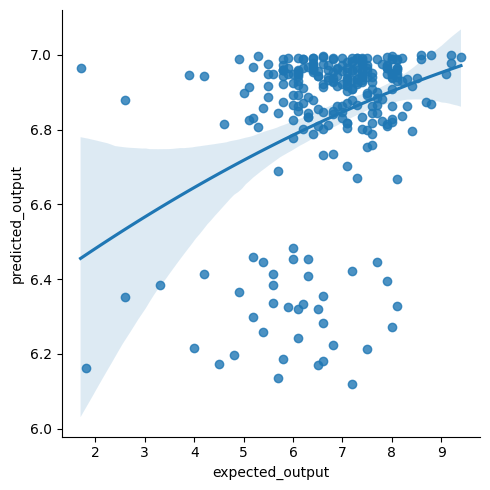

In [17]:
print("sdg")
sgd_regression(features, X_train, y_train, X_test, y_test)

In [18]:
print("Random forest")
random_forest_regression(X_train, y_train, X_test, y_test)

Random forest
Random Forest Regression Results:
The r2 is: 0.13111271306428618
The rmse is: 1.0872050557253121


RandomForestRegressor(random_state=42)

lin hyperparameters tuning
Mean Squared Error: 1.2424918389944397
Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'positive': False}
Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'positive': False}
Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'positive': False}
Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'positive': False}
Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'positive': False}
Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'positive': False}
Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'positive': False}
Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'positive': False}
Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'positive': False}
Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'positive': False}
Mean Squared Error (Final Model): 1.242604834666209
The r2 is:  0.08665667070707916
coefficient of determination: 

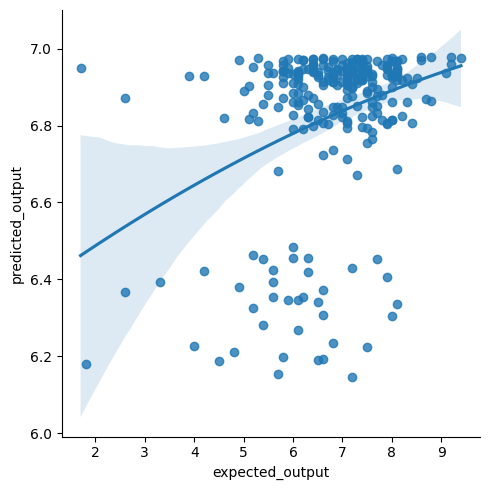

In [19]:
print("lin hyperparameters tuning")
linear_hyperparamets_tuning(X_train, y_train, X_test, y_test)

In [20]:
print("knn")
knn_regression(X_train, y_train, X_test, y_test)

knn
KNN regression training started...
Training completed!
The r2 is:  -0.10087267316911586
The rmse is:  1.2237657310381762
coefficient of determination: -0.10087267316911586
      expected_output  predicted_output
1203              7.4          7.360000
293               8.3          7.800000
943               6.9          6.750000
977               8.1          7.320000
514               6.0          5.811765
...               ...               ...
455               6.3          4.998135
21                8.0          6.827485
802               6.0          5.400000
521               5.6          5.657293
425               7.3          7.220000

[266 rows x 2 columns]


linear regression
Linear regression training started...
Training completed!
The r2 is:  0.08665667070707916
The rmse is:  1.1146711797630904
coefficient of determination: 0.08665667070707916
      expected_output  predicted_output
1203              7.4          6.960681
293               8.3          6.923868
943               6.9          6.905457
977               8.1          6.948430
514               6.0          6.884795
...               ...               ...
455               6.3          6.842999
21                8.0          6.931875
802               6.0          6.934989
521               5.6          6.423943
425               7.3          6.952513

[266 rows x 2 columns]
Linear regression results written to /kaggle/working/results_lr_2024-01-05_14:17:02.802440.csv
Creating plot of the results...
Plots of the results successfully created!
Plots of the results successfully saved at /kaggle/working/results_lr_2024-01-05_14:17:02.802440_regplot.png!


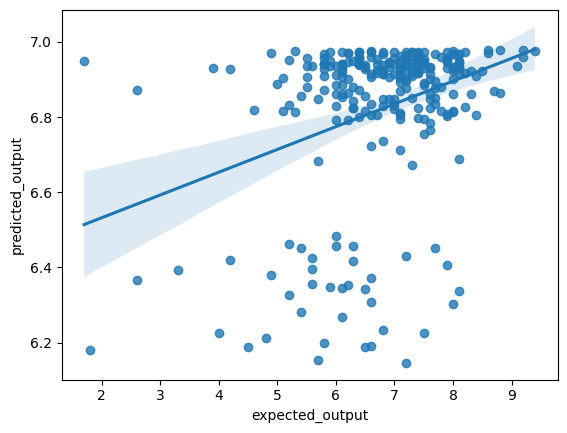

In [21]:
print("linear regression")
linear_regression()

polynomial_regression
Polynomial regression data transformation started...
Data transformation completed!
Transformed data: 
[[1.00000000e+00 2.01400000e+03 2.09718400e+06 4.22372858e+09]
 [1.00000000e+00 2.01000000e+03 8.51968000e+06 1.71245568e+10]
 [1.00000000e+00 1.98900000e+03 3.67001620e+07 7.29966222e+10]
 ...
 [1.00000000e+00 2.00100000e+03 1.31360000e+05 2.62851360e+08]
 [1.00000000e+00 2.00900000e+03 3.36527360e+07 6.76083466e+10]
 [1.00000000e+00 2.00200000e+03 2.22822400e+06 4.46090445e+09]]
Polynomial regression training started...
Training completed!
The r2 is:  0.08593527080178054
The rmse is:  1.115111301750677
coefficient of determination: 0.08593527080178054
intercept: -0.617270051103354
      expected_output  predicted_output
1203              7.4          6.958223
293               8.3          6.924262
943               6.9          6.905163
977               8.1          6.946923
514               6.0          6.886064
...               ...               ...
455  

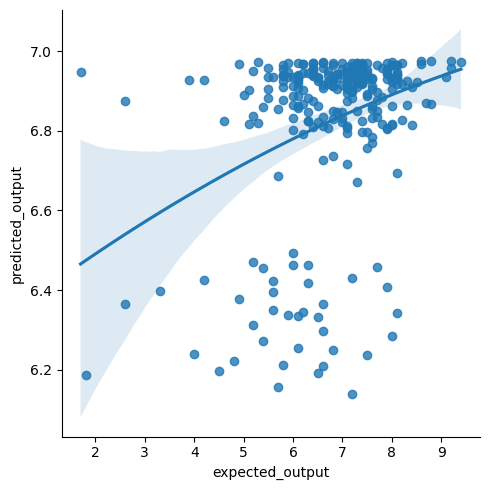

In [22]:
print("polynomial_regression")
polynomial_regression()

In [23]:
print("polynomial_regression testy")
polynomial_regression_testy()

polynomial_regression testy
Polynomial regression data transformation started...
Polynomial regression training started...
Training completed!
The r2 is:  0.0859348785772931
The rmse is:  1.1151115409973618
coefficient of determination: 0.0859348785772931
intercept: -0.6163293953552689


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.10649e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
